In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf

SEED = 2017

In [ ]:
# Data can be downloaded at https://www.kaggle.com/c/facial-keypoints-detection/data

In [6]:
DIR = 'Data/faces/'
training_file = pd.read_csv(DIR + 'training.csv')

cols = training_file.columns[:-1]
training_file['Image'] = training_file['Image'].apply(lambda Image: np.fromstring(Image, sep=' '))
training_file = training_file.dropna()

In [7]:
img_cols = 96
img_rows = 96
img_channels = 1
n_labels = 30 # 15 times x, y pairs

X = np.vstack(training_file['Image'])
X = X.reshape(-1, img_cols, img_rows, 1)
y = training_file[cols].values

X = X / 255.
y = y / 96.

print(X.shape, y.shape)

(2140, 96, 96, 1) (2140, 30)


In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

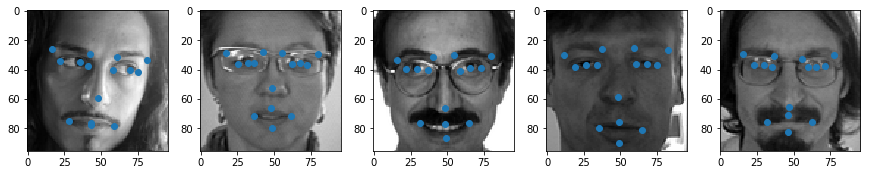

In [9]:
plt.figure(figsize=(15, 15))

n_examples = 5
for i in range(n_examples):
    plt.subplot(n_examples, n_examples, i+1)
    rand = np.random.randint(len(X_train))
    img = X_train[rand].reshape(img_cols, img_rows)
    plt.imshow(img, cmap='gray')
    kp = y_train[rand]
    plt.scatter(kp[0::2] * img_cols, kp[1::2] * img_rows)

plt.show()

In [15]:
 def model(data, dropout=1.0):
    conv = tf.nn.conv2d(data, conv1_weights, strides=[1, 1, 1, 1], padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))
    pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    conv = tf.nn.conv2d(pool, conv2_weights, strides=[1, 1, 1, 1], padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
    pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])

    hidden1 = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
    hidden1 = tf.nn.dropout(hidden1, dropout, seed=SEED)

    hidden2 = tf.nn.relu(tf.matmul(hidden1, fc2_weights) + fc2_biases)
    hidden2 = tf.nn.dropout(hidden2, dropout, seed=SEED)
    
    output = tf.matmul(hidden2, fc3_weights) + fc3_biases

    return output

In [26]:
batch_size = 128
n_epochs = 500
learning_rate = 1e-4
print_every = 10
early_stopping_patience = 5

In [27]:
inputs = tf.placeholder(tf.float32, shape=(batch_size, img_cols, img_rows, img_channels))
targets = tf.placeholder(tf.float32, shape=(batch_size, n_labels))

evals = tf.placeholder(tf.float32, shape=(batch_size, img_cols, img_rows, img_channels))

conv1_weights = tf.Variable(tf.truncated_normal([5, 5, img_channels, 32], stddev=0.1,seed=SEED))
conv1_biases = tf.Variable(tf.zeros([32]))

conv2_weights = tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1, seed=SEED))
conv2_biases = tf.Variable(tf.constant(0.1, shape=[64]))

fc1_weights = tf.Variable(tf.truncated_normal([img_cols // 4 * img_rows // 4 * 64, 512], stddev=0.1, seed=SEED))
fc1_biases = tf.Variable(tf.constant(0.1, shape=[512]))

fc2_weights = tf.Variable(tf.truncated_normal([512, 512], stddev=0.1, seed=SEED))
fc2_biases = tf.Variable(tf.constant(0.1, shape=[512]))

fc3_weights = tf.Variable(tf.truncated_normal([512, n_labels], stddev=0.1, seed=SEED))
fc3_biases = tf.Variable(tf.constant(0.1, shape=[n_labels]))

In [29]:
val_size = X_val.shape[0]

train_prediction = model(inputs, 0.5)
loss = tf.reduce_mean(tf.reduce_sum(tf.square(train_prediction - targets), 1))
eval_prediction = model(evals)

train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)

history = []
patience_count = 0
for epoch in range(n_epochs):
    for step in range(int(len(X_train) / batch_size)):
        offset = step * batch_size
        batch_data = X_train[offset:(offset + batch_size), ...]
        batch_labels = y_train[offset:(offset + batch_size)]

        feed_dict = {inputs: batch_data, targets: batch_labels}
        _, loss_train = sess.run([train_step, loss], feed_dict=feed_dict)
    
    predictions = np.ndarray(shape=(val_size, n_labels), dtype=np.float32)    
    for begin in range(0, val_size, batch_size):
        end = begin + batch_size
        if end <= val_size:
            predictions[begin:end, :] = sess.run(eval_prediction, feed_dict={evals: X_val[begin:end, ...]})
        else:
            batch_predictions = sess.run(eval_prediction, feed_dict={evals: X_val[-batch_size:, ...]})
            predictions[begin:, :] = batch_predictions[begin - val_size:, :]    
    loss_val = np.sum(np.power(predictions - y_val, 2)) / (2 * predictions.shape[0])
    history.append(loss_val)
    if epoch % print_every == 0:
        print('Epoch {:04d}: train loss {:.8f}; validation loss {:.8f}'.format(epoch, loss_train, loss_val))
    if epoch > 0 and history[epoch-1] > history[epoch]:
        patience_count = 0
    else:
        patience_count += 1
 
    if patience_count > early_stopping_patience:
        break

Epoch 0000: train loss 1315.19226074; validation loss 57.15657018
Epoch 0010: train loss 6.52086210; validation loss 2.62981516
Epoch 0020: train loss 5.17016125; validation loss 1.94537345
Epoch 0030: train loss 3.84035540; validation loss 1.36718656
Epoch 0040: train loss 3.01924086; validation loss 0.92241077
Epoch 0050: train loss 2.32450318; validation loss 0.60166818
Epoch 0060: train loss 1.86521292; validation loss 0.38333133
Epoch 0070: train loss 1.60102391; validation loss 0.24256982
Epoch 0080: train loss 1.44401002; validation loss 0.15679964
Epoch 0090: train loss 1.30055428; validation loss 0.10698474
Epoch 0100: train loss 1.24145126; validation loss 0.07878533
Epoch 0110: train loss 1.13065004; validation loss 0.06287614
Epoch 0120: train loss 1.08849430; validation loss 0.05426487
Epoch 0130: train loss 1.09431493; validation loss 0.04913718
Epoch 0140: train loss 1.06148851; validation loss 0.04668750
Epoch 0150: train loss 0.95161796; validation loss 0.04488998
Epoc

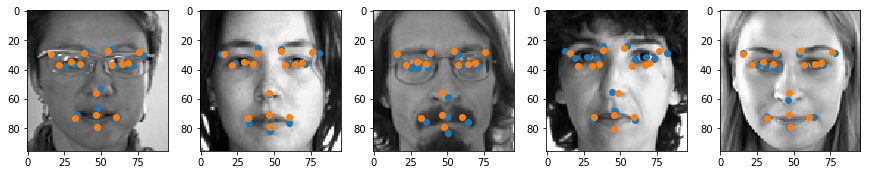

In [30]:
plt.figure(figsize=(15, 15))

n_examples = 5
for i in range(n_examples):
    plt.subplot(n_examples, n_examples, i+1)
    rand = np.random.randint(len(X_val))
    img = X_val[rand].reshape(img_cols, img_rows)
    plt.imshow(img, cmap='gray')
    kp = y_val[rand]
    pred = predictions[rand]
    plt.scatter(kp[0::2] * img_cols, kp[1::2] * img_rows)
    plt.scatter(pred[0::2] * img_cols, pred[1::2] * img_rows)

plt.show()